In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [19]:
def mask2rle(img, width=1024, height=1024, max_color=1):
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == max_color:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel+=1

    return " ".join(rle)

def rle2mask(rle, width=1024, height=1024, max_color=255):
    mask = np.zeros(width * height)
    """WARNING: This function should only be used in SIIM dataset because it constains .T() transformation here"""
    if rle == '-1': return mask.reshape(width, height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = max_color
        current_position += lengths[index]
    """WARNING: This function should only be used in SIIM dataset because it constains .T() transformation here"""
    return mask.reshape(width, height)

In [3]:
def draw(image, vmin=0, vmax=1):
    F = plt.figure()
    plt.imshow(np.squeeze(image), cmap='plasma', vmin=vmin, vmax=vmax)
    plt.grid(False)
def get_metadata_by_id(path):
    ds = pydicom.dcmread(path)
    return ds.PatientAge, ds.PatientSex, ds.PixelSpacing, ds.ReferringPhysicianName, ds.SeriesDescription, ds.ViewPosition

def get_load_image_by_id(path):
    ds = pydicom.read_file(path)
    return np.array(ds.pixel_array)

# Making Mixed Labels

In [2]:
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle-mix.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 1...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 10...


In [4]:
dataset_dict = dict()
dataset_id = dataset['ImageId']
dataset_set = set(dataset_id.to_list())
print("Unique Size: {} Actual Size: {}".format(len(dataset_set), len(dataset_id)))
for id in dataset_set:
    dataset_dict[id] = dataset.loc[dataset_id == id]['EncodedPixels']
dataset_dict

Unique Size: 10675 Actual Size: 11582


{'1.2.276.0.7230010.3.1.4.8323329.13726.1517875247.412197.dcm': 6826    -1
 Name: EncodedPixels, dtype: object,
 '1.2.276.0.7230010.3.1.4.8323329.14006.1517875249.93352.dcm': 3591    -1
 Name: EncodedPixels, dtype: object,
 '1.2.276.0.7230010.3.1.4.8323329.5587.1517875188.903880.dcm': 11469    -1
 Name: EncodedPixels, dtype: object,
 '1.2.276.0.7230010.3.1.4.8323329.1469.1517875167.950672.dcm': 9228    -1
 Name: EncodedPixels, dtype: object,
 '1.2.276.0.7230010.3.1.4.8323329.372.1517875162.608228.dcm': 8445    213226 10 1011 14 1008 18 1003 22 1000 23 999 ...
 8446    239133 1 1019 6 1017 7 1015 10 1013 11 1012 12...
 8447    589951 2 1019 8 1014 11 1011 13 1009 16 1007 1...
 8448    126496 27 992 37 982 52 968 61 961 73 949 88 9...
 8449    214256 1 1020 8 1012 11 1011 13 1009 14 1007 1...
 Name: EncodedPixels, dtype: object,
 '1.2.276.0.7230010.3.1.4.8323329.31942.1517875157.591754.dcm': 10000    -1
 Name: EncodedPixels, dtype: object,
 '1.2.276.0.7230010.3.1.4.8323329.12980.15178752

In [5]:
def get_mask_sum(encodes):
#     print("This has length: {}".format(length))
    masks = []
    for encode in encodes:
        mask = rle2mask(encode)
#         plt.imshow(mask)
        masks.append(mask)
#     print("Original Pixels: {}".format(np.array(masks).sum()/256))
    masks = (np.array(masks).sum(axis=0) > 0).astype(np.byte)
#     print("Transformed Pixels: {}".format(masks.sum()/1))
    
    """Testing if encode is correct"""
#     plt.imshow(masks)
#     plt.imshow(rle2mask(mask2rle(masks)))

    masks = mask2rle(masks)
    return masks
    
new_dataset = dict()
pbar = tqdm(dataset_dict.items())
for i, (id, encodes) in enumerate(pbar):
    encodes = encodes.to_list()
    length = len(encodes)
    mask = encodes
    if length > 1:
        mask = [get_mask_sum(mask)]
    assert len(mask) == 1
    new_dataset[i] = [id, mask[0]]

In [6]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels'])
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.13726.15178752...,-1
1,1.2.276.0.7230010.3.1.4.8323329.14006.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.5587.151787518...,-1
3,1.2.276.0.7230010.3.1.4.8323329.1469.151787516...,-1
4,1.2.276.0.7230010.3.1.4.8323329.372.1517875162...,126496 27 992 37 982 52 968 61 961 73 949 88 9...


In [7]:
df.to_csv(NEW_PATH, index=False)

# Adding Metadata & Saving to `.npy` - Train

In [14]:
SAVE = False
IMG_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/siim-original/dicom-images-train"
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle-mix.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle-mix-added.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.13726.15178752...,-1
1,1.2.276.0.7230010.3.1.4.8323329.14006.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.5587.151787518...,-1
3,1.2.276.0.7230010.3.1.4.8323329.1469.151787516...,-1
4,1.2.276.0.7230010.3.1.4.8323329.372.1517875162...,126496 27 992 37 982 52 968 61 961 73 949 88 9...


In [10]:
for id in dataset['ImageId'].to_list():
    print(dataset.loc[dataset['ImageId'] == id].to_dict())
    break

{'ImageId': {0: '1.2.276.0.7230010.3.1.4.8323329.13726.1517875247.412197.dcm'}, 'EncodedPixels': {0: '-1'}}


In [15]:
# imageid = []
# encodedpixels = []
# PatientAge = []
# PatientSex = []
# PixelSpacing = []
# ReferringPhysicianName = []
# SeriesDescription = []
# ViewPosition = []

new_dataset = dict()
num_saved = 0

pbar = tqdm(dataset.iterrows())
for i, (index, row) in enumerate(pbar):
#     imageid.append(row['ImageId'])
#     encodedpixels.append(row['EncodedPixels'])
    path = os.path.join(IMG_PATH, row['ImageId'])
    a,b,c,d,e,f = get_metadata_by_id(path)
    
    save_path = path.replace(".dcm", ".npy")
    if SAVE and not os.path.isfile(save_path):
        np.save(save_path, get_load_image_by_id(path))
        num_saved = num_saved + 1
    pbar.set_description("num_saved = {}".format(num_saved))
    
#     PatientAge.append(a)
#     PatientSex.append(b)
#     PixelSpacing.append(c)
#     ReferringPhysicianName.append(d)
#     SeriesDescription.append(e)
#     ViewPosition.append(f)
    if SAVE:
        new_dataset[i] = [row['ImageId'].replace(".dcm", ".npy"), row['EncodedPixels'], a,b,c,d,e,f]
    else:
        new_dataset[i] = [row['ImageId'], row['EncodedPixels'], a,b,c,d,e,f]


In [16]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels', 'PatientAge', 'PatientSex', 'PixelSpacing', 'ReferringPhysicianName', 'SeriesDescription', 'ViewPosition'])
df.head()

,ImageId,EncodedPixels,PatientAge,PatientSex,PixelSpacing,ReferringPhysicianName,SeriesDescription,ViewPosition
0,1.2.276.0.7230010.3.1.4.8323329.13726.15178752...,-1,69,M,"[0.14300000000000002, 0.14300000000000002]",,view: PA,PA
1,1.2.276.0.7230010.3.1.4.8323329.14006.15178752...,-1,46,F,"[0.168, 0.168]",,view: AP,AP
2,1.2.276.0.7230010.3.1.4.8323329.5587.151787518...,-1,54,F,"[0.14300000000000002, 0.14300000000000002]",,view: PA,PA
3,1.2.276.0.7230010.3.1.4.8323329.1469.151787516...,-1,48,F,"[0.168, 0.168]",,view: AP,AP
4,1.2.276.0.7230010.3.1.4.8323329.372.1517875162...,126496 27 992 37 982 52 968 61 961 73 949 88 9...,34,M,"[0.19431099999999998, 0.19431099999999998]",,view: PA,PA


In [17]:
df.to_csv(NEW_PATH, index=False)

# Adding Metadata & Saving to `.npy` - Test

In [70]:
SAVE = False
IMG_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/siim-original/dicom-images-test"
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/sample_submission.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/sample_submission-added.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6567.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6170.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6346.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6890.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6400.151787519...,-1


In [69]:
# imageid = []
# encodedpixels = []
# PatientAge = []
# PatientSex = []
# PixelSpacing = []
# ReferringPhysicianName = []
# SeriesDescription = []
# ViewPosition = []

new_dataset = dict()
num_saved = 0

pbar = tqdm(dataset.iterrows())
for i, (index, row) in enumerate(pbar):
#     imageid.append(row['ImageId'])
#     encodedpixels.append(row['EncodedPixels'])
    path = os.path.join(IMG_PATH, row['ImageId'] + ".dcm")
    a,b,c,d,e,f = get_metadata_by_id(path)
    
    save_path = path.replace(".dcm", ".npy")
    if SAVE and not os.path.isfile(save_path):
        np.save(save_path, get_load_image_by_id(path))
        num_saved = num_saved + 1
    pbar.set_description("num_saved = {}".format(num_saved))
    
#     PatientAge.append(a)
#     PatientSex.append(b)
#     PixelSpacing.append(c)
#     ReferringPhysicianName.append(d)
#     SeriesDescription.append(e)
#     ViewPosition.append(f)
    if SAVE:
        new_dataset[i] = [row['ImageId'].replace(".dcm", ".npy"), row['EncodedPixels'], a,b,c,d,e,f]
    else:
        new_dataset[i] = [row['ImageId'], row['EncodedPixels'], a,b,c,d,e,f]


In [71]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels', 'PatientAge', 'PatientSex', 'PixelSpacing', 'ReferringPhysicianName', 'SeriesDescription', 'ViewPosition'])
df.head()

,ImageId,EncodedPixels,PatientAge,PatientSex,PixelSpacing,ReferringPhysicianName,SeriesDescription,ViewPosition
0,1.2.276.0.7230010.3.1.4.8323329.6567.151787519...,-1,80,F,"[0.168, 0.168]",,view: AP,AP
1,1.2.276.0.7230010.3.1.4.8323329.6170.151787519...,-1,62,F,"[0.139, 0.139]",,view: PA,PA
2,1.2.276.0.7230010.3.1.4.8323329.6346.151787519...,-1,30,F,"[0.19431099999999998, 0.19431099999999998]",,view: PA,PA
3,1.2.276.0.7230010.3.1.4.8323329.6890.151787520...,-1,49,F,"[0.14300000000000002, 0.14300000000000002]",,view: PA,PA
4,1.2.276.0.7230010.3.1.4.8323329.6400.151787519...,-1,65,F,"[0.14300000000000002, 0.14300000000000002]",,view: PA,PA


# Leakage Usage

In [59]:
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/old_sample_submission_leakage.csv"
NEW_PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle-leak.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.9488.151787521...,-1
1,1.2.276.0.7230010.3.1.4.8323329.7388.151787520...,-1
2,1.2.276.0.7230010.3.1.4.8323329.8104.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.952.1517875165...,-1
4,1.2.276.0.7230010.3.1.4.8323329.680.1517875164...,-1


In [60]:
dic = dict()

# count each appearance
for id in dataset['ImageId'].tolist():
    if id not in dic.keys():
        dic[id] = 1
    else:
        dic[id] = dic[id] + 1

# classify each appearance
appear = dict()
for id, appearance in dic.items():
    if dic[id] not in appear.keys():
        appear[dic[id]] = [id]
    else:
        appear[dic[id]].append(id)

print(appear) # we know that multiple appearance is not empty

{1: ['1.2.276.0.7230010.3.1.4.8323329.9488.1517875218.175563', '1.2.276.0.7230010.3.1.4.8323329.7388.1517875204.201431', '1.2.276.0.7230010.3.1.4.8323329.8104.1517875209.54822', '1.2.276.0.7230010.3.1.4.8323329.952.1517875165.756716', '1.2.276.0.7230010.3.1.4.8323329.680.1517875164.49743', '1.2.276.0.7230010.3.1.4.8323329.586.1517875163.569244', '1.2.276.0.7230010.3.1.4.8323329.7050.1517875202.507168', '1.2.276.0.7230010.3.1.4.8323329.600.1517875163.632969', '1.2.276.0.7230010.3.1.4.8323329.8303.1517875210.164933', '1.2.276.0.7230010.3.1.4.8323329.6707.1517875199.622316', '1.2.276.0.7230010.3.1.4.8323329.9338.1517875217.483777', '1.2.276.0.7230010.3.1.4.8323329.6652.1517875199.400704', '1.2.276.0.7230010.3.1.4.8323329.8599.1517875212.789106', '1.2.276.0.7230010.3.1.4.8323329.8129.1517875209.182736', '1.2.276.0.7230010.3.1.4.8323329.6115.1517875196.616758', '1.2.276.0.7230010.3.1.4.8323329.6682.1517875199.532073', '1.2.276.0.7230010.3.1.4.8323329.8507.1517875212.328410', '1.2.276.0.7230

In [61]:
l = []
for key, item in appear.items():
    if key != 1:
        l = l + item
print("There are {} images we can use in the test set.".format(len(l)))

new_dataset = dict()
for i, id in enumerate(l):
    new_dataset[i] = [id, "Non-Empty"]

There are 248 images we can use in the test set.


In [62]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels'])
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.828.1517875165...,Non-Empty
1,1.2.276.0.7230010.3.1.4.8323329.9840.151787522...,Non-Empty
2,1.2.276.0.7230010.3.1.4.8323329.841.1517875165...,Non-Empty
3,1.2.276.0.7230010.3.1.4.8323329.5803.151787519...,Non-Empty
4,1.2.276.0.7230010.3.1.4.8323329.6797.151787520...,Non-Empty


In [63]:
df.to_csv(NEW_PATH, index=False)

# Left and Right Correlation

In [2]:
PATH = "/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/siim_dataset/train-rle.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 1...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 10...


## Left Right Difference in Shape

In [36]:
encodeds = dataset["EncodedPixels"].tolist()
pbar = tqdm(encodeds)
n = len(pbar)
m = np.zeros((1024, 1024))
for encoded in pbar:
    mask = rle2mask(encoded)
    if mask.sum() != 0:
        mask = np.transpose(mask)
        m = m + mask
m_absolute = (m > 0).astype(np.byte)

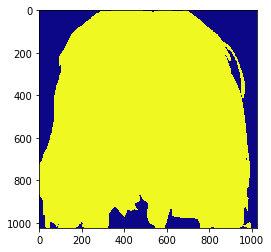

In [37]:
draw(m_absolute)

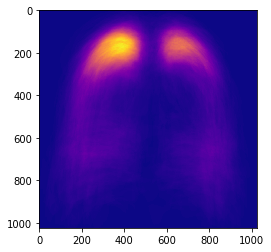

In [52]:
draw(m, m.min(), m.max())

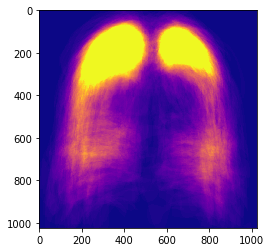

In [56]:
draw(m, m.min(), m.min()+255*100)

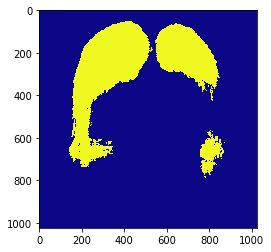

In [46]:
draw((m > 255*50).astype(np.byte))

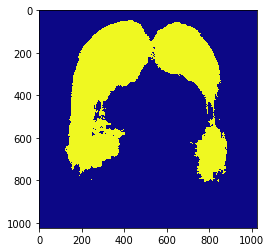

In [57]:
draw((m > 255*40).astype(np.byte))

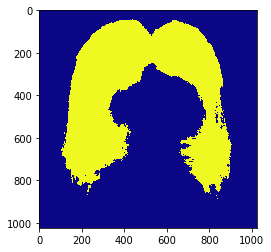

In [58]:
draw((m > 255*30).astype(np.byte))

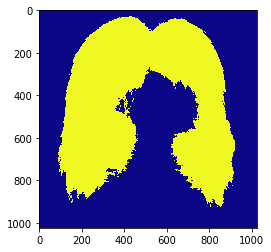

In [55]:
draw((m > 255*20).astype(np.byte))

## Left Right Difference in Probability

In [23]:
left_only_total = 0
right_only_total = 0
left_right_total = 0
empty = 0

encodeds = dataset["EncodedPixels"].tolist()
pbar = tqdm(encodeds)
for encoded in pbar:
    mask = rle2mask(encoded)
    mask = np.transpose(mask)
    if mask.sum() != 0:
        mask_left = mask[:,:512]
        mask_right = mask[:,513:]
        if mask_left.sum() != 0 and mask_right.sum() != 0:
            left_right_total = left_right_total + 1
            continue
        else:
            if mask_left.sum() != 0 and mask_right.sum() == 0:
                left_only_total = left_only_total + 1
                continue
            if mask_left.sum() == 0 and mask_right.sum() != 0:
                right_only_total = right_only_total + 1
                continue
    else:
        empty = empty +1
        continue
print("There are {} left, {} right, {} combined, {} empty".format(left_only_total, right_only_total, left_right_total, empty))


There are 1756 left, 1336 right, 194 combined, 8296 empty


In [28]:
total = left_only_total + right_only_total + left_right_total + empty
print("The chance of having left is {}".format(left_only_total/total))
print("The chance of having right is {}".format(right_only_total/total))
print("Thereotical chance of having combined is {}".format((right_only_total/total)*(left_only_total/total)))
print("Actual chance of having combined is {}".format(left_right_total/total))
print("There is a difference of {} case out of {} case".format(total * ((right_only_total/total)*(left_only_total/total)) - (left_right_total/total), total))

The chance of having left is 0.15161457433949233
The chance of having right is 0.11535140735624244
Thereotical chance of having combined is 0.017488954525778082
Actual chance of having combined is 0.016750129511310656
There is a difference of 202.54032118805043 case out of 11582 case


In [31]:
left_only_total = 0
right_only_total = 0
left_right_total = 0
empty = 0

encodeds = dataset["EncodedPixels"].tolist()[:int(11582/2)]
pbar = tqdm(encodeds)
for encoded in pbar:
    mask = rle2mask(encoded)
    mask = np.transpose(mask)
    if mask.sum() != 0:
        mask_left = mask[:,:512]
        mask_right = mask[:,513:]
        if mask_left.sum() != 0 and mask_right.sum() != 0:
            left_right_total = left_right_total + 1
            continue
        else:
            if mask_left.sum() != 0 and mask_right.sum() == 0:
                left_only_total = left_only_total + 1
                continue
            if mask_left.sum() == 0 and mask_right.sum() != 0:
                right_only_total = right_only_total + 1
                continue
    else:
        empty = empty +1
        continue
print("There are {} left, {} right, {} combined, {} empty".format(left_only_total, right_only_total, left_right_total, empty))


There are 1655 left, 1260 right, 191 combined, 2685 empty


In [32]:
total = left_only_total + right_only_total + left_right_total + empty
print("The chance of having left is {}".format(left_only_total/total))
print("The chance of having right is {}".format(right_only_total/total))
print("Thereotical chance of having combined is {}".format((right_only_total/total)*(left_only_total/total)))
print("Actual chance of having combined is {}".format(left_right_total/total))
print("There is a difference of {} case out of {} case".format(total * ((right_only_total/total)*(left_only_total/total)) - (left_right_total/total), total))

The chance of having left is 0.28578829217751683
The chance of having right is 0.21757900189949922
Thereotical chance of having combined is 0.062181531366546576
Actual chance of having combined is 0.032982213780003454
There is a difference of 360.0602659298912 case out of 5791 case


So we can clearly see that left and right are independent, or even negatively dependent. That is very strange. Also note that the chance of having the disease on the left chest is much higher.  

It seems like AP and PA all have correct orientation of left chest or right chest.  
So, new augmentation includes:
 - erase half
 - cut paste half

# Reverse Mask

In [20]:
PATH = "/home/koke_cacao/Downloads/f1be1364-CP59_F[0]_PTsiimv132_VTf1be1364_LR0.00015_BS6_IMG512.pth-25540f7d-F0-T0.99-Prob-TTA0.csv"
NEW_PATH = "/home/koke_cacao/Downloads/f1be1364-CP59_F[0]_PTsiimv132_VTf1be1364_LR0.00015_BS6_IMG512.pth-25540f7d-F0-T0.99-Prob-TTA0-Inverse.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,899629 2 1021 4 1017 14 1009 16 1007 18 1005 2...
1,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,895529 8 1015 10 1013 12 1011 14 1010 14 1010 ...
2,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,893481 12 1011 14 1007 18 1005 20 1003 22 1001...
3,1.2.276.0.7230010.3.1.4.8323329.6294.151787519...,83784 1 7 1 1013 12 1004 1 7 13 1001 24 1000 2...
4,1.2.276.0.7230010.3.1.4.8323329.6105.151787519...,827626 1 1022 3 1020 4 1020 4 1021 4 1021 4 10...


In [21]:
dataset_dict = dict()
dataset_encodes = dataset['EncodedPixels'].tolist()
dataset_id = dataset['ImageId'].tolist()

new_dataset = dict()
pbar = tqdm(zip(dataset_id, dataset_encodes))
for i, (id, encode) in enumerate(pbar):
    if str(encode) == "nan":
        new_dataset[i] = [id, "-1"]
        continue
    encode = mask2rle(np.transpose(rle2mask(encode, max_color=1)), max_color=1)
    new_dataset[i] = [id, encode]

In [22]:
df = pd.DataFrame.from_dict(new_dataset, orient='index', columns=['ImageId', 'EncodedPixels'])
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,559993 5 1018 7 1016 9 1014 10 1011 13 1010 15...
1,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,527233 5 1018 7 1016 9 1014 11 1012 13 1010 15...
2,1.2.276.0.7230010.3.1.4.8323329.5879.151787519...,529281 7 1016 8 1015 9 1014 11 1013 12 1012 12...
3,1.2.276.0.7230010.3.1.4.8323329.6294.151787519...,172382 18 1005 20 977 54 969 56 961 68 955 70 ...
4,1.2.276.0.7230010.3.1.4.8323329.6105.151787519...,238378 2 1021 4 1019 10 1015 10 1017 10 1015 1...


In [23]:
df.to_csv(NEW_PATH, index=False)